# Exploring Gini and Lorenz

See Bernasco and Steenbeck - *More Places than Crimes: Implications for Evaluating
the Law of Crime Concentration at Place*

Specifically identifying a baseline curve from which a concentration measure can be computed 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson

from spatial import SpatialUnit, get_census_boundaries, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    Month,
    calc_adjusted_gini,
    calc_gini,
    load_crime_data,
    lorenz_curve,
    monthgen,
    poisson_lorenz_area,
    random_crime_data_by_feature,
    random_crime_data_by_point,
)

Set up parameters: 
- crime type
- force and spatial units
- time window

In [3]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "GRID"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 800.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)
LATEST_DATE = Month(2025, 5)
MONTHS = 36

## Part 1: inspect some real data

Get the data, place in the spatial units and aggregate to crime counts per spatial unit per month

In [4]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = load_crime_data(
    FORCE, monthgen(LATEST_DATE, end=LATEST_DATE - MONTHS), filters={"Crime type": CATEGORY}
)
# remove any points outside boundary
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])

count_data = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(count_data) == len(features)

count_data

Month,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculate and display Lorenz curves for each month


<Axes: title={'center': 'Lorenz Curves for Crime Counts by Month'}>

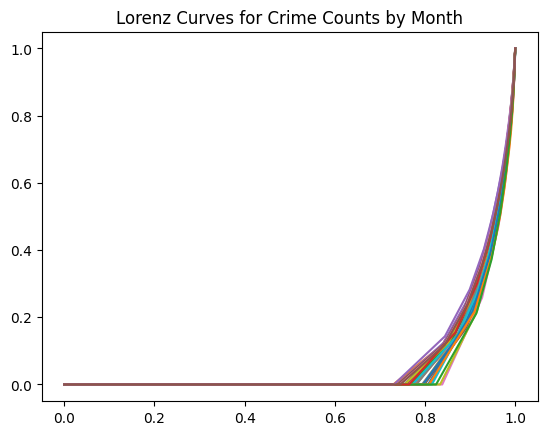

In [5]:
data = {m: lorenz_curve(c) for m, c in count_data.items()}
lorenz_curves = pd.DataFrame(data)
lorenz_curves.plot(legend=False, title="Lorenz Curves for Crime Counts by Month")

## Part 2: Simulate

Using the same crime count and number of spatial units from the real data, we simulate random *i.i.d.* crimes to 
demonstrate that:
- the assumption in the standard Gini formula - that the Lorenz curve is a straight line from (0, 0) to (1, 1) is flawed.
- to produce such a curve would require a space-filling (and thus non-independent) stochastic process.
- any independent process will naturally have clusters and gaps, and is incorrect to infer any causality from this 
observation

The biggest deviation from the original Gini assumption is most obvious when there are zeros in the data, e.g. when the 
number of spatial units is greater than the crime count.

TODO something wrong with this logic? NOTE: this assumes the same Poisson intensity $\lambda$ in each spatial unit, which may not be the case. I think the 
Poisson-Gamma work tries to address this.


In [6]:
n_spatial_units = len(features)
n_crimes_per_month = round(count_data.sum().mean())

lambda_ = n_crimes_per_month / n_spatial_units
f"{n_crimes_per_month=} {n_spatial_units=} {lambda_=}"  # the mean count of incidents

'n_crimes_per_month=2284 n_spatial_units=3370 lambda_=0.6777448071216617'

Construct a Poisson distribution, simulate crimes and aggregate to spatial units

The Poisson PDF is

$$
f(k; \lambda) = \frac{\lambda^ke^{-\lambda}}{k!}
$$

where $k$ is the observed count and $\lambda$ the mean, which can be expressed as the ratio of crimes/crime rates $C$ to spatial 
units $N$:

$$
\lambda = \frac{C}{N}
$$

Of particular interest here is situations where $C<N$.

In [7]:
rng = np.random.default_rng()


def get_sample(n_spatial_units, n_crimes_per_month) -> pd.Series:
    raw = rng.choice(range(n_spatial_units), n_crimes_per_month)
    indices, counts = np.unique(raw, return_counts=True)

    sample = pd.Series(index=indices, data=counts).reindex(range(n_spatial_units), fill_value=0)
    return sample


sample = get_sample(n_spatial_units, n_crimes_per_month)
counts = (sample.groupby(sample).count() / n_spatial_units).rename("sim").to_frame()

Check the simulation by comparing to the PDF

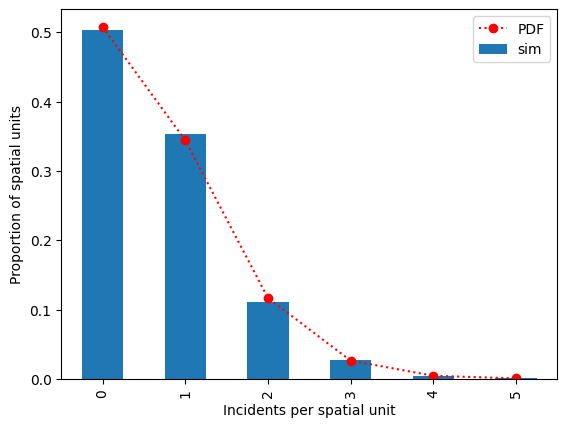

In [8]:
dist = poisson(lambda_)

counts["pdf"] = counts.index.map(dist.pmf)  # * n_spatial_units
ax = counts.sim.plot.bar()
ax.plot(counts.pdf, ":", c="r", marker="o", label="PDF")
ax.set_xlabel("Incidents per spatial unit")
ax.set_ylabel("Proportion of spatial units")
ax.legend();

## Show that aggregrated spatially random data follows a Poisson distribution

- regular geometries - **will be edge effects from features with lower than expected counts**
- statistical geographies (requires even sampling by spatial unit, **will not work for evenly sampled points aggregrated to spatial units of different sizes**)

Text(0.5, 1.0, 'Irregular features (sampled by point)')

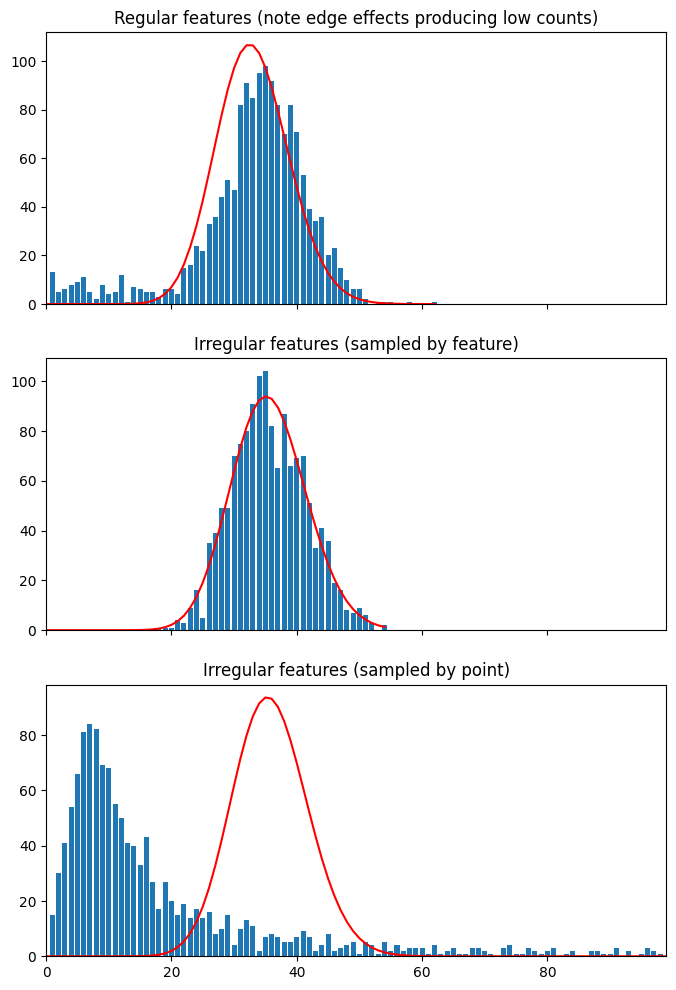

In [ ]:
N = 50000
raw_random_crimes = random_crime_data_by_point(N, force_boundary, [LATEST_DATE], seed=19937)
random_crimes_c_by_point, features_c = map_to_spatial_unit(raw_random_crimes, force_boundary, "LSOA")
# mean area of LSOA is ~1200**2
random_crimes_r, features_r = map_to_spatial_unit(raw_random_crimes, force_boundary, "GRID", size=1200)

random_crimes_c = random_crime_data_by_feature(N, features_c, [LATEST_DATE], seed=19937)

counts_r = random_crimes_r.groupby("spatial_unit")["Crime type"].count()
counts_c = random_crimes_c.groupby("spatial_unit")["Crime type"].count()
# counts biased towards larger geographies
counts_c_biased = random_crimes_c_by_point.groupby("spatial_unit")["Crime type"].count()

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

dist_r = poisson(counts_r.mean())
hist_r = np.bincount(counts_r)
k = list(range(len(hist_r)))
axs[0].bar(k, hist_r)
axs[0].plot(k, dist_r.pmf(k) * len(features_r), c="r")
axs[0].set_xlim(0, 3 * counts_r.mean())
axs[0].set_title("Regular features (note edge effects producing low counts)")

dist_c = poisson(counts_c.mean())
hist_c = np.bincount(counts_c)
k = list(range(len(hist_c)))
axs[1].bar(k, hist_c)
axs[1].plot(k, dist_c.pmf(k) * len(features_c), c="r")
axs[1].set_title("Irregular features (sampled by feature)")

dist_c_wrong = poisson(counts_c_biased.mean())
hist_c_wrong = np.bincount(counts_c_biased)
k = list(range(len(hist_c_wrong)))
axs[2].bar(k, hist_c_wrong)
axs[2].plot(k, dist_c_wrong.pmf(k) * len(features_c), c="r")
axs[2].set_title("Irregular features (sampled by point)")

## Lorenz curve

The theoretical Lorenz curve for independent samples is the cumulative sum of inverse CDF 
$Q(x; \lambda) = F^{-1}(x; \lambda)$ of the Poisson distribution

$$
L_0(x) = \int_0^x{Q(t; \lambda) dt} \bigg/ \int_0^1{Q(t; \lambda) dt}
$$

We call this the "null hypothesis" curve and show how it deviates significantly from the original Gini assumption

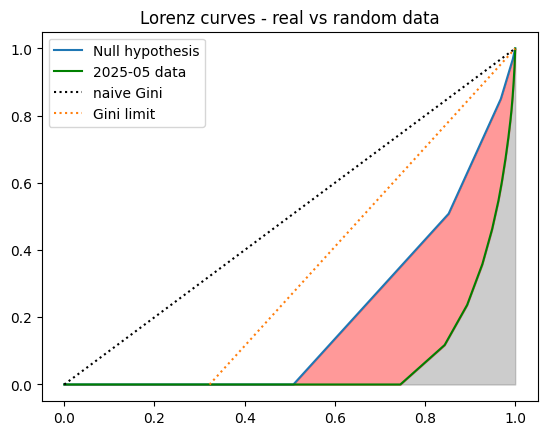

In [10]:
lorenz0 = lorenz_curve(sample)
# icdf = dist.ppf(lorenz0.index)
# icdf[0] = 0
# lorenz["analytic"] = icdf.cumsum() / n_crimes_per_month
# lorenz.loc[1.0, "analytic"] = 1.0
ax = lorenz0.plot(label="Null hypothesis", title="Lorenz curves - real vs random data")
lorenz_curves["2025-05"].plot(ax=ax, label="2025-05 data", c="g")
ax.plot([0, 1], [0, 1], ":", c="k", label="naive Gini")

ax.plot([max(0, 1 - lambda_), 1], [0, 1], ":", label="Gini limit")

ax.fill_between(lorenz_curves.index, 0, lorenz_curves["2025-05"], color="grey", alpha=0.4)
ax.fill_between(lorenz_curves.index, lorenz_curves["2025-05"], lorenz0, color="r", alpha=0.4)
ax.legend();

## Part 3: Adjusted Gini calculation and comparison

The standard Gini coefficient (for the green curve) is given by twice the area bounded by it and the black dotted line, 
which can be written as

$$
Gini = 1 - 2A
$$

where A is the area under the (green) Lorenz curve $L(x)$ - the grey shaded area above

$$
A = \int_0^1{L(x)dx}
$$

We define our adjusted Gini coefficient as the ratio of the area between the actual $L(x)$ and "null-hypothesis" 
$L_0(x)$ Lorenz curves with the total area under the null hypothesis curve:

$$
Gini^\prime = \frac{A_0 - A}{A_0}
$$

The "null hypothesis" Lorenz curve (blue line) is defined as the set of points

$$
(F(k; \lambda), F(k-1; \lambda)) \text{ for } k=0..\infty
$$

and so the area $A_0$ (the grey and red shared areas above) can be computed analytically from the Poisson PDF 
$f(k; \lambda)$ and CDF $F(k; \lambda)$:

$$
A_0 = \sum_{k=1}^\infty {f(k; \lambda)\frac{(F(k-1; \lambda) + F(k-2; \lambda))}{2}}
$$

here CDF values for negative $k$ are zero.

### Adjusted Gini bounds

The maximally-dispersed bound for the Lorenz curve is the black dotted line when there is enough population to occupy 
all spatial units, corresponding to $\lambda\ge1$. When $\lambda<1$ there will be at least $N - C$ empty spatial units, 
the Lorenz curve will be bounded by the yellow dotted line in the graph above and the maximum value of $A$ will be:

$$
A = C/2N = \lambda/2
$$

The upper bound for adjusted Gini is always 1, like the traditional value.

Unlike traditional Gini, this adjusted Gini is not a hard limit - it is possible for a population to be more dispersed 
than would be expected randomly, producing a negative value, within the constraint desribed above the lower bound is:

$$
Gini^{\prime}_{min} = \frac{A_0 - min(1, \lambda)/2}{A_0}
$$

The graph below shows how these quantities vary for a range of $\lambda$

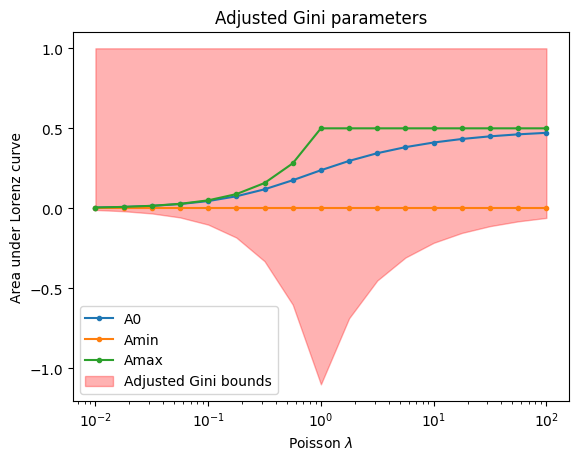

In [11]:
bounds = pd.DataFrame(data={"lambda": np.logspace(-2, 2, 17)})
bounds["A0"] = bounds["lambda"].map(poisson_lorenz_area)
bounds["Amin"] = 0
bounds["Amax"] = np.minimum(bounds["lambda"], 1) / 2
bounds["Gini1 upper"] = 1
bounds["Gini1 lower"] = (bounds.A0 - bounds.Amax) / bounds.A0
ax = bounds.set_index("lambda")[["A0", "Amin", "Amax"]].plot(
    logx=True,
    marker=".",
    ylabel="Area under Lorenz curve",
    xlabel="Poisson $\\lambda$",
    title="Adjusted Gini parameters",
)
ax.fill_between(
    bounds["lambda"], bounds["Gini1 lower"], bounds["Gini1 upper"], color="r", alpha=0.3, label="Adjusted Gini bounds"
)
ax.legend()

## Gini vs Adjusted Gini Comparison

36 x monthly crime counts

Naive Gini       0.874503
Adjusted Gini    0.680215
dtype: float64

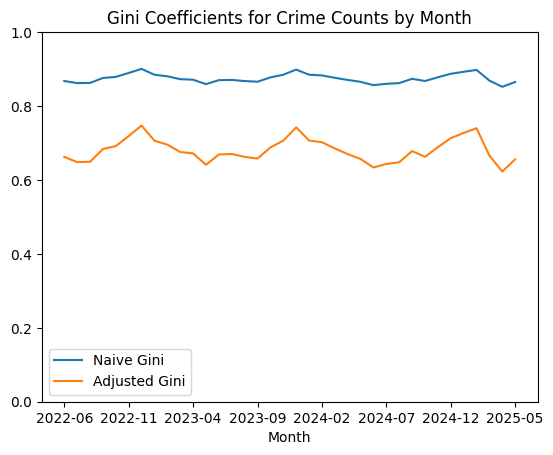

In [32]:
gini = pd.DataFrame(index=count_data.columns)

gini["Naive Gini"] = gini.index.map(lambda m: calc_gini(count_data[m])[0])
gini["Adjusted Gini"] = gini.index.map(lambda m: calc_adjusted_gini(lorenz_curves[m], lambda_))
ax = gini.plot(ylim=(0, 1), title="Gini Coefficients for Crime Counts by Month")
gini.mean()

## Do we have any scale invariance?

Generate random data and see how Gini and adjusted Gini vary by spatial scale

### Adjusted Gini should be ~0 for purely random data

In [14]:
N = len(crime_data) // 36
AREA: SpatialUnit = "GRID"

In [51]:
def compute_spatial_variation(
    raw_random_crimes: gpd.GeoDataFrame, boundary: gpd.GeoDataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # evenly spaced log(area) scale
    size = np.exp(np.linspace(np.log(100**2), np.log(5000**2), 12) / 2)

    lorenz_curves = []
    gini = pd.DataFrame(index=size, columns=["Naive Gini", "Adjusted Gini", "L", "A0"])

    for size in gini.index:
        random_crimes, features = map_to_spatial_unit(raw_random_crimes, boundary, AREA, size=size)

        count_data = random_crimes.groupby("spatial_unit")["Crime type"].count().reindex(features.index, fill_value=0)
        assert len(count_data) == len(features)

        lambda_ = len(raw_random_crimes) / len(features)
        A0 = poisson_lorenz_area(lambda_)

        gini.loc[size, "A0"] = A0

        gc, lc = calc_gini(count_data)
        gini.loc[size, "Naive Gini"] = gc

        gini.loc[size, "Adjusted Gini"] = calc_adjusted_gini(lc, lambda_)
        gini.loc[size, "L"] = lc.mean()

        lorenz_curves.append(lc.rename(f"{size:.0f}m"))

    return pd.concat(lorenz_curves, axis=1), gini


def plot_lorenz_gini(lorenz_curves: pd.DataFrame, gini: pd.DataFrame, desc: str) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Lorenz and Gini by grid size, {desc}")
    lorenz_curves.plot(
        ax=axs[0], title="Lorenz curves", xlabel="Cumulative spatial units", ylabel="Cumultative crime", legend=True
    )
    gini.plot(
        ax=axs[1],
        title="Gini coefficient",
        logx=True,
        ylim=axs[0].get_ylim(),
        xlabel="Grid size (m)",
        ylabel="Concentraion",
        marker=".",
    )

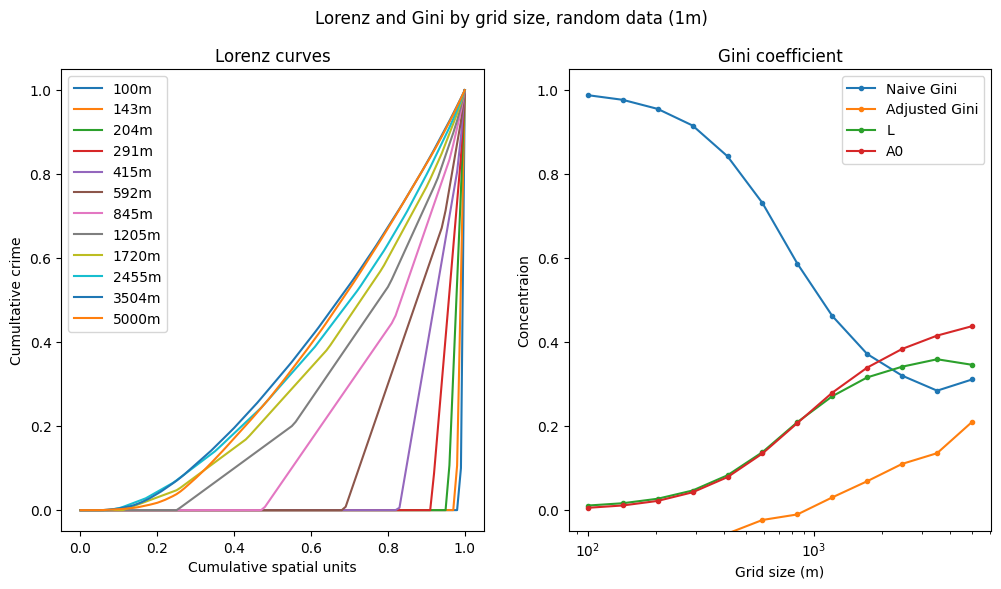

In [31]:
raw_random_crimes = random_crime_data_by_point(N, force_boundary, [LATEST_DATE], seed=19937)
random_lorenz_curves, random_gini = compute_spatial_variation(raw_random_crimes, force_boundary)
plot_lorenz_gini(random_lorenz_curves, random_gini, "random data (1m)")

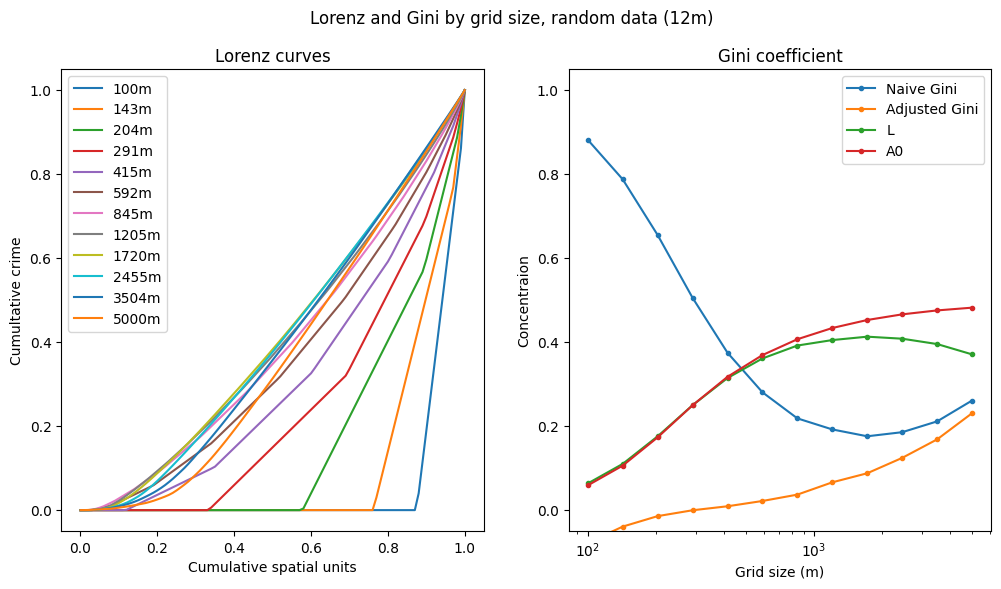

In [33]:
raw_random_crimes = random_crime_data_by_point(N * 12, force_boundary, [LATEST_DATE], seed=19937)
random_lorenz_curves, random_gini = compute_spatial_variation(raw_random_crimes, force_boundary)
plot_lorenz_gini(random_lorenz_curves, random_gini, "random data (12m)")

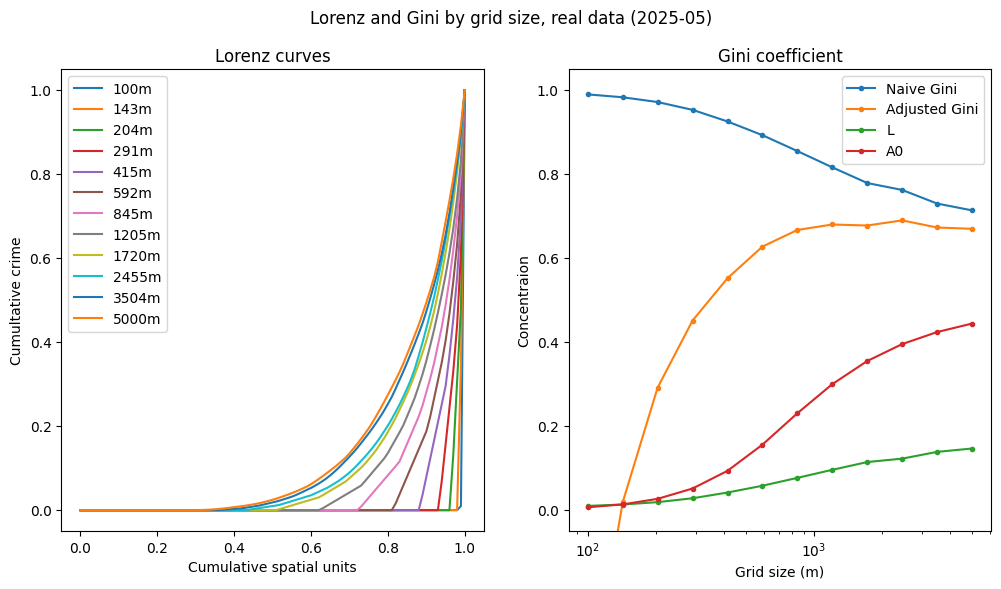

In [52]:
m = LATEST_DATE
real_lorenz_curves, real_gini = compute_spatial_variation(
    raw_crime_data[raw_crime_data.Month == str(m)], force_boundary
)
plot_lorenz_gini(real_lorenz_curves, real_gini, f"real data ({m})")

In [19]:
raw_crime_data_3m = raw_crime_data[raw_crime_data.Month > "2024-02"]
raw_crime_data_3m.loc[:, "Month"] = "(1y)"
real_lorenz_curves_3m, real_gini_3m = compute_spatial_variation(raw_crime_data_3m, force_boundary)
plot_lorenz_gini(real_lorenz_curves_3m, real_gini_3m, f"real data {m - 2} to {m}")

NameError: name 'compute_spatial_variation' is not defined

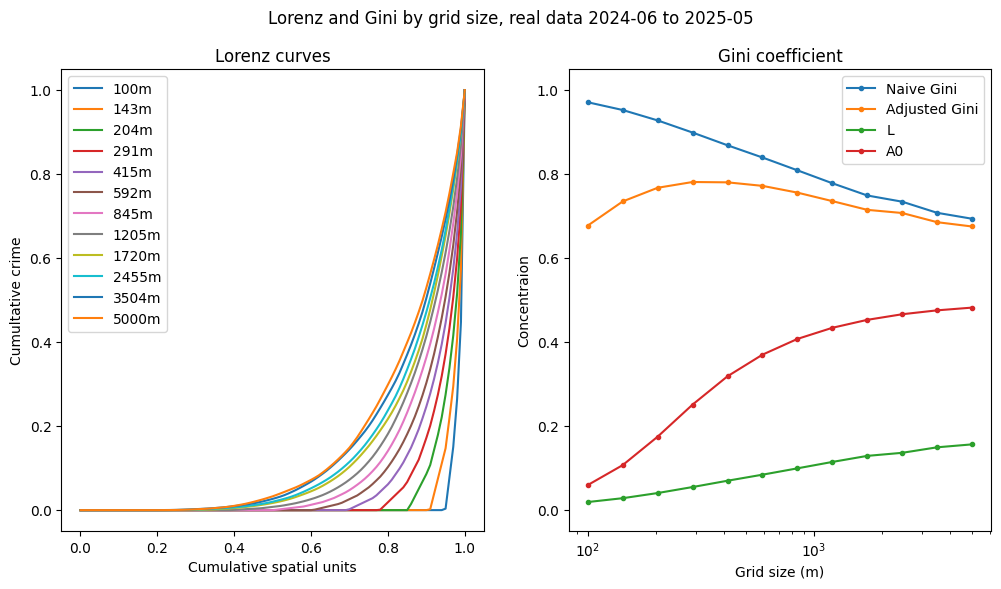

In [38]:
raw_crime_data_1y = raw_crime_data[raw_crime_data.Month > "2024-05"]
raw_crime_data_1y.loc[:, "Month"] = "(1y)"
real_lorenz_curves_1y, real_gini_1y = compute_spatial_variation(raw_crime_data_1y, force_boundary)
plot_lorenz_gini(real_lorenz_curves_1y, real_gini_1y, f"real data {m - 11} to {m}")

### Points to note

- **Naive Gini decreases as spatial scale increases**
- **Adjusted Gini changes less rapidly with spatial scale** 
- **Adjusted Gini tends to increase initially and flatten out**
- **Adjusted Gini tends to increase with spatial scale for random data, why???**
- **Adjusted Gini for real data at the smallest spatial scale indicates strong dispersion which vanishes at the next scale**